In [1]:
import pandas as pd

In [14]:
reviews = pd.read_csv('../data/reviews_sample.csv')

reviews.shape

(1000, 10)

In [15]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,416669,B000EMD1XW,A2HW3HFAEX4JN3,Annette Neeley,1,1,5,1311379200,Favorite Tea,Cannot find this in stores anymore. I'm not su...
1,475332,B001KP4VMC,A3IUW081KXD3PE,pixels and bits,1,1,5,1251849600,High marks for Chukar's toppings!,I regularly order Chukar's pie fillings and to...
2,565645,B002GKEK7G,A2QUKCW69I9JUP,Jill H Anderson,1,1,5,1318982400,"love it, love it, love it!",I was looking for something that would satisfy...
3,190110,B000E18CWI,ACZIC2GCCFA0R,Sunbob,2,4,5,1194566400,Great buy on Thai noodles,"This is a great deal, plus a % off coupon. Mu..."
4,511270,B004FGWU9O,A3UROAHZHOIMTR,"Maria ""andrewsm51""",0,1,2,1318896000,Mediocre,This coffee is only mediocre in quality. I do ...


<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

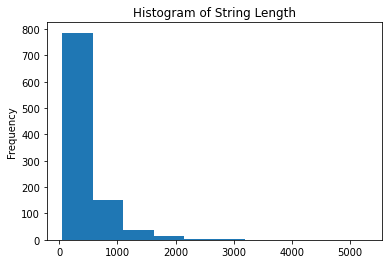

In [16]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

In [17]:
reviews['len'] = reviews['Text'].str.len()
reviews = reviews[reviews['len'] < 150][reviews['len'] > 100]

reviews.shape

<ipython-input-17-de870841e023>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews = reviews[reviews['len'] < 150][reviews['len'] > 100]


(133, 11)

In [18]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive'  if x >=  4 else 'negative')

<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

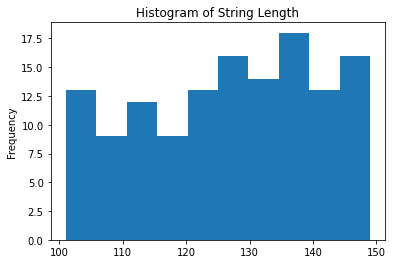

In [19]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

<AxesSubplot:>

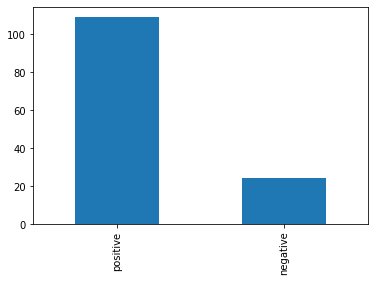

In [20]:
reviews['Sentiment'].value_counts().plot(kind='bar')

In [21]:
reviews_sample = reviews.groupby('Sentiment').sample(25)

reviews_sample.shape

ValueError: Cannot take a larger sample than population when 'replace=False'

In [25]:
reviews_sample = reviews

In [26]:
from transformers import GPT2Tokenizer

MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'


# Uncomment these lines to add the two tokens to the tokenizer as brand new tokens

# special_words_to_add={"additional_special_tokens": [SENTIMENT_TOKEN, SUMMARIZE_TOKEN]}
# tokenizer.add_special_tokens(special_words_to_add)


<AxesSubplot:>

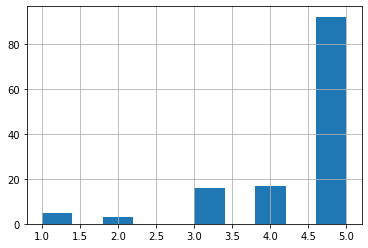

In [27]:
reviews_sample['Score'].hist()

In [28]:
reviews_sample['sentiment_text'] = 'Review: ' + reviews_sample['Text'] + SENTIMENT_TOKEN +  ' ' + reviews_sample['Sentiment'].astype(str)

reviews_sample['summarize_text'] = 'Review: ' + reviews_sample['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews_sample['Summary'].astype(str)


In [29]:
reviews_sample['sentiment_text'].head(2).tolist()

['Review: Thank goodness for this brand of pasta. It tates just like pasta with gluten only better! Not grainy, mushy, and the texture is perfect!\nSentiment: positive',
 'Review: My favorite Flavored coffee!!! This is not available in any of my local stores.  Better price than I have found at any local stores as well.\nSentiment: positive']

In [30]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [31]:
reviews_sample['summarize_text'].head(2).tolist()

['Review: Thank goodness for this brand of pasta. It tates just like pasta with gluten only better! Not grainy, mushy, and the texture is perfect!\nSummarize: Best pasta ever!',
 'Review: My favorite Flavored coffee!!! This is not available in any of my local stores.  Better price than I have found at any local stores as well.\nSummarize: My favorite k cup']

In [32]:
# TODO don't repeat utterances

In [33]:
reviews_sample = reviews_sample.sample(frac=1)

In [34]:
mid_point = reviews_sample.shape[0]//2


training_examples = reviews_sample['summarize_text'].head(mid_point).tolist() + reviews_sample['sentiment_text'].tail(mid_point).tolist()



In [35]:
multi_task_df = pd.DataFrame({'text': training_examples})

multi_task_df.shape

(132, 1)

In [36]:
print(multi_task_df['text'][1])

Review: If all I wanted was a date flavored bar I'd have bought a date bar.  As a date bar they're ok, just relabel them as such.
Summarize: Banana Bread and Pecan Pie


In [38]:
print(multi_task_df['text'][10])

Review: My dog is very picky but she will eat this, and it is so good for her.<br />I will definitely keep buying this.
Summarize: My Dog loves this


In [39]:
from datasets import Dataset
data = Dataset.from_pandas(multi_task_df)
data

Dataset({
    features: ['text'],
    num_rows: 132
})

In [40]:
MAX_TOKENS = 256

# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples):
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples['text'],
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding='max_length',
    )
    
    output['labels'] =  output["input_ids"]
    # -100 is a reserved value to ignore these tokens when calculating the loss
    output["labels"] = [[-100 if x == tokenizer.pad_token_id else x for x in y] for y in output["labels"]]
    return output

data = data.map(
    tokenize_function,
    batched=True,
)
print(data)


  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 132
})


In [41]:
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])

data = data.train_test_split(test_size=0.20, shuffle=True, seed=0)
print(data)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 105
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 27
    })
})


In [42]:
tokenizer.decode(data['train'][0]['input_ids'])

'Review: This product is the perfect brew every time and I can have my cold glass of tea in less than a minute!\nSentiment: positive<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex

In [43]:
tokenizer.decode([c for c  in data['train'][0]['labels'] if c != -100])

'Review: This product is the perfect brew every time and I can have my cold glass of tea in less than a minute!\nSentiment: positive'

In [44]:
len(data['train'][0]['input_ids'])

256

In [45]:
len(data['train'][0]['labels'])

256

In [46]:
len(data['train'][0]['attention_mask'])

256

In [47]:
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(MODEL)

# Update the model embeddings with the new vocabulary size IF we added new special tokens
# model.resize_token_embeddings(len(tokenizer))

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [48]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=4, # number of training epochs
    per_device_train_batch_size=64, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=50,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    logging_steps=5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
)

In [49]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 27
  Batch size = 64


{'eval_loss': 4.274802207946777,
 'eval_runtime': 22.1977,
 'eval_samples_per_second': 1.216,
 'eval_steps_per_second': 0.045}

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running training *****
  Num examples = 105
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss


In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline

loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline(
    'text-generation', model=loaded_model, tokenizer=tokenizer,
    config={'max_length': 200,  'do_sample': False}
)

In [ ]:
random.sample(data['test'])['text']

In [ ]:
text_sample, score, summary = reviews_sample.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

In [ ]:
num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

In [ ]:
sentiment_text_sample = f'Review: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'Review: {text_sample}{SUMMARIZE_TOKEN}'

print(sentiment_text_sample)
print(summarize_text_sample)

In [ ]:
encoded_input = tokenizer(sentiment_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=encoded_input['input_ids'].shape[1] + 1,
        temperature=0.2,
        top_k=2
    )[0]))

In [ ]:
encoded_input = tokenizer(summarize_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=len(encoded_input['input_ids']) + 15,
        temperature=0.5,
        beams=2,
        top_k=10,
        no_repeat_ngram_size=2,
    )[0], skip_special_tokens=True))

In [ ]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=2, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    

In [ ]:
for generated_text in generator(summarize_text_sample, num_return_sequences=2, max_length=num_tokens + 15):
    print(generated_text['generated_text'])
    